# Quality Assessment


In [1]:
import pandas as pd

In [2]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1M1GZO9GiSAfpCNOWMvT0_cMQXYfiNk_I/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

In [3]:
# orderlines_cl.csv
url = "https://drive.google.com/file/d/1pAwW8JPLq8DmHEAb7lIqWOBNQ_vBidn7/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

In [4]:
# products_cl.csv
url = "https://drive.google.com/file/d/1d-EfhdIsaCvlPx_xy1D0GM7w5OhVQ2lR/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

Load our cleaned DataFrames

## 1.&nbsp; Define Pandas display format

In [5]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

 For our analysis on discount we're interested in only `completed` orders and `Place Order`. So let's filter our DataFrame.

In [6]:
orders_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226904 entries, 0 to 226903
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226904 non-null  int64  
 1   created_date  226904 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226904 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [7]:
orders_cl2 = orders_cl.loc[orders_cl["state"].isin(["Completed", "Place Order"]),:]

In [8]:
orders_cl.groupby("state")["order_id"].count()

state
Cancelled            7233
Completed           46605
Pending             14374
Place Order         40883
Shopping Basket    117809
Name: order_id, dtype: int64

In [9]:
orders_cl2.groupby("state")["order_id"].count()

state
Completed      46605
Place Order    40883
Name: order_id, dtype: int64

## 3.&nbsp; Exclude orders with unknown products
Keep only order_ids that are present in orders and orderlines,
Keep only order_ids that contain products with valid SKUS.
Exclude  complete order_ids, when single orderlines do not qualify.

In [10]:
#Rename id_order to match orderlines nameing
orderlines_cl = orderlines_cl.rename(columns={"id_order":"order_id"})

In [11]:
#Store all ids from orders table in list
order_ids = orders_cl2["order_id"].to_list()

In [12]:
#Keep only order_ids that are in the orders table
orderlines_qu = orderlines_cl.loc[orderlines_cl["order_id"].isin(order_ids),:].copy()

In [13]:
#Merge with orders to match both sides
ord_orderlines_qu = orderlines_qu.merge(orders_cl,how="inner")

In [14]:
ids_in_both_list = list(ord_orderlines_qu["order_id"].unique())

In [15]:
#Create the merged version in both singular DFs
orderlines_qu = orderlines_qu.loc[orderlines_cl["order_id"].isin(ids_in_both_list),:]

In [16]:
#Create the merged version in both singular DFs
orders_qu = orders_cl2.loc[orders_cl2["order_id"].isin(ids_in_both_list),:].copy()

In [17]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["order_id"].unique()))

(75139, 75139)

In [18]:
products_cl["sku"].describe()

count       10104
unique      10104
top       RAI0007
freq            1
Name: sku, dtype: object

In [19]:
#Secure the consistency of SKUs -- all skus from the product table
skus_known= products_cl["sku"].to_list()

In [20]:
#There are orders in the orderlines table with unknown SKUS - need to be dropped
orderlines_qu.sku.isin(skus_known).value_counts()

True     94619
False     1934
Name: sku, dtype: int64

In [21]:
#Find order_ids that do not have these SKUS
orders_with_skus = orderlines_qu.loc[~(orderlines_qu["sku"].isin(skus_known)),"order_id"].to_list()

In [22]:
#Exclude these order_ids in orderlines
orderlines_qu = orderlines_qu.loc[~(orderlines_qu["order_id"].isin(orders_with_skus)),:]

In [23]:
#Exclude in orders
orders_qu = orders_qu.loc[~(orders_qu["order_id"].isin(orders_with_skus)),:]

In [24]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93349 entries, 1 to 293980
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                93349 non-null  int64  
 1   order_id          93349 non-null  int64  
 2   product_id        93349 non-null  int64  
 3   product_quantity  93349 non-null  int64  
 4   sku               93349 non-null  object 
 5   unit_price        93349 non-null  float64
 6   date              93349 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 5.7+ MB


In [25]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["order_id"].unique()))

(73221, 73221)

In [26]:
# last step backwards - to products table
sku_ordered = orderlines_qu.sku.unique()

In [27]:
products_qu = products_cl.loc[products_cl.sku.isin(sku_ordered),:].copy()

## 3.1&nbsp;  Merging the cleaned dataframes

In [32]:
#orderlines merging with orders only inner join
all_orders_qu = orderlines_qu.merge(orders_qu,how = "inner", left_on="order_id", right_on="order_id" )

In [33]:
#merging new df with products on sku inner join
all_orders_qu = all_orders_qu.merge(products_qu, how="inner", left_on="sku", right_on="sku")

In [34]:
all_orders_qu = all_orders_qu.drop(columns="product_id", axis = 1)

In [35]:
all_orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93349 entries, 0 to 93348
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                93349 non-null  int64  
 1   order_id          93349 non-null  int64  
 2   product_quantity  93349 non-null  int64  
 3   sku               93349 non-null  object 
 4   unit_price        93349 non-null  float64
 5   date              93349 non-null  object 
 6   created_date      93349 non-null  object 
 7   total_paid        93349 non-null  float64
 8   state             93349 non-null  object 
 9   name              93349 non-null  object 
 10  desc              93349 non-null  object 
 11  price             93349 non-null  float64
 12  promo_price       93349 non-null  object 
 13  type              93349 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 10.7+ MB


## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [36]:
all_orders_qu["unit_price_total"] = all_orders_qu.unit_price * all_orders_qu.product_quantity

#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [37]:
# price per order_id - with groupby
price_p_order = all_orders_qu.groupby("order_id", as_index=False).agg({"unit_price_total":"sum"})

In [40]:
price_p_order.head()

,order_id,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98


### What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
orders_qu_copy = orders_qu.copy()

In [41]:
#Create a second Grouped DF with the total_paid items
total_paid = all_orders_qu.groupby("order_id", as_index=False).agg(item_count =("unit_price","count"),sum_paid=("total_paid","sum"))

In [42]:
#Divide the sum of the total paid by amoutn of items - as it is total in every orderline
total_paid["paid_per_order"] = (total_paid.sum_paid / total_paid.item_count).round(2)

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [43]:
#Merge the results
price_comp = price_p_order.merge(total_paid)

In [49]:
#Drop the sum paid column was just a temporary step to calculate tp per order
price_comp= price_comp.drop("sum_paid",axis = 1)

Now that we know the difference for each order, we can compute the average.

In [48]:
# New column with price differences
price_comp["differences"] = (price_comp.paid_per_order - price_comp.unit_price_total).round(2)

In [50]:
price_comp.describe()
# Most of the results between 1.99 and 4.99 --> Delivery prices

,order_id,unit_price_total,item_count,paid_per_order,differences
count,73221.00,73221.00,73221.00,73221.00,73221.00
mean,412520.93,427.05,1.27,430.43,3.38
std,65551.55,771.78,0.71,771.31,19.89
min,241423.00,2.49,1.00,0.00,-165.00
25%,358260.00,49.96,1.00,51.98,0.00
50%,413943.00,125.99,1.00,129.99,3.99
75%,468608.00,411.99,1.00,413.99,4.99
max,527401.00,17910.34,25.00,17910.37,3984.99


### What is the distribution of these differences?

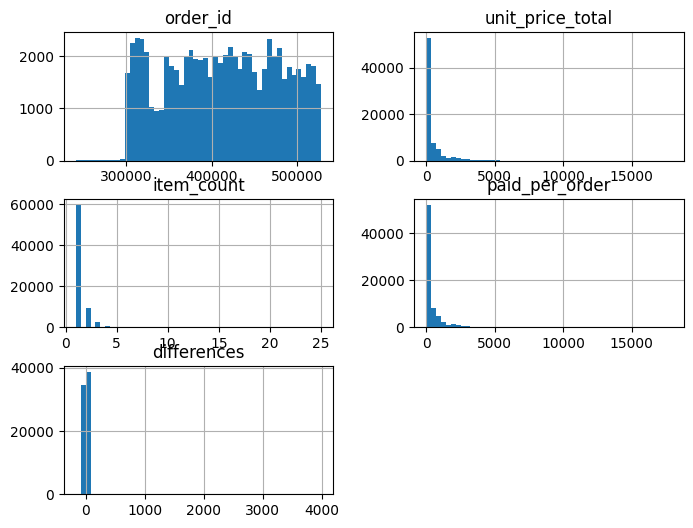

In [52]:
price_comp.hist(bins= 50, figsize=(8,6));

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [53]:
# Exclude the Outliers via Quartile calculation
Q3= price_comp.differences.quantile(0.75)
Q1 = price_comp.differences.quantile(0.25)
IQR = Q3-Q1
outlier_plus = round((Q3 + 1.5*IQR),1)

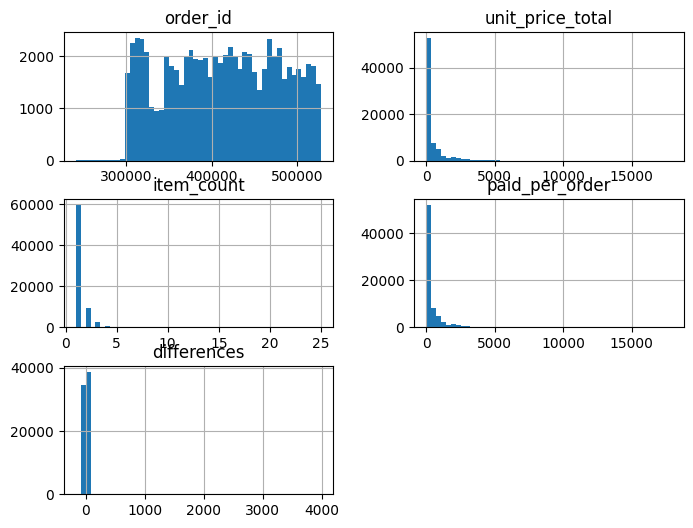

In [54]:
price_comp.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [56]:
price_comp.differences.describe()

count   73221.00
mean        3.38
std        19.89
min      -165.00
25%         0.00
50%         3.99
75%         4.99
max      3984.99
Name: differences, dtype: float64

In [57]:
outlier_plus

12.5

In [58]:
# Keep only data between 0 and + 12 Euro in the difference
price_comp_qu = price_comp.loc[((price_comp.differences > -0.01)&(price_comp.differences < outlier_plus)),: ].copy()

In [59]:
price_comp_qu.describe()

,order_id,unit_price_total,item_count,paid_per_order,differences
count,71225.00,71225.00,71225.00,71225.00,71225.00
mean,412553.85,427.24,1.27,430.19,2.95
std,65399.23,771.07,0.70,770.37,3.00
min,241423.00,2.49,1.00,2.49,0.00
25%,358371.00,48.98,1.00,50.98,0.00
50%,413908.00,124.98,1.00,128.89,3.99
75%,468430.00,409.00,1.00,409.39,4.99
max,527401.00,17910.34,25.00,17910.37,11.99


In [60]:
#Define the Order Ids with the outlier prices
outlier_order_ids = price_comp.loc[(price_comp.differences <= -0.01)|(price_comp.differences > outlier_plus),"order_id" ].copy().to_list()

In [61]:
print(len(outlier_order_ids))

1996


In [62]:
#Reduce the Dataframes accordingly
orders_qu2 = orders_qu.loc[~(orders_qu.order_id.isin(outlier_order_ids)),:].copy()
orderlines_qu2 = orderlines_qu.loc[~(orderlines_qu.order_id.isin(outlier_order_ids)),:].copy()
all_orders_qu2 = all_orders_qu.loc[~(all_orders_qu.order_id.isin(outlier_order_ids)),:].copy()

In [63]:
orders_qu2.shape

(71225, 4)

In [64]:
orderlines_qu2.shape

(90348, 7)

In [65]:
# both dfs should be the same size
len(list(orders_qu2["order_id"].unique())), len(list(orderlines_qu2["order_id"].unique()))

(71225, 71225)

In [66]:
all_orders_qu2.describe()

,id,order_id,product_quantity,unit_price,total_paid,price,unit_price_total
count,90348.00,90348.00,90348.00,90348.00,90348.00,90348.00,90348.00
mean,1380701.04,412384.30,1.11,323.24,507.23,366.81,336.81
std,150025.87,65115.15,2.75,627.12,939.64,697.20,652.85
min,1119116.00,241423.00,1.00,0.01,2.49,2.99,0.01
25%,1256275.00,358813.75,1.00,31.44,56.98,43.90,32.99
50%,1382236.50,413746.00,1.00,81.99,153.98,99.99,86.99
75%,1508774.75,467874.50,1.00,288.99,486.87,359.00,309.00
max,1650203.00,527401.00,800.00,14725.00,17910.37,15339.00,14725.00


## 5.&nbsp;  Calculate the Discounts between base price and current

Base prices should not be lower than actual prices (negative Discounts)

In [67]:
#Rearrange the Column order
all_orders_qu2 = all_orders_qu2[["id","order_id","sku","name", "desc", "type", "created_date","date","state", "unit_price", "product_quantity","unit_price_total", "price","total_paid" ]]

In [68]:
all_orders_qu2.set_index("id")

,order_id,sku,name,desc,type,created_date,date,state,unit_price,product_quantity,unit_price_total,price,total_paid
id,,,,,,,,,,,,,
1119126,299549,PAC0929,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,2017-01-02 10:00:20,2017-01-01 02:07:42,Completed,2565.99,1,2565.99,3209.00,2565.99
1173758,321056,PAC0929,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,2017-02-07 19:17:55,2017-02-07 18:57:17,Completed,2721.99,1,2721.99,3209.00,2721.99
1174256,321299,PAC0929,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,2017-02-08 12:40:15,2017-02-08 12:33:10,Completed,2721.99,1,2721.99,3209.00,2721.99
1119131,299553,APP1854,"Apple MacBook Pro 13 ""with Touch Bar 33GHz Cor...",New MacBook Pro 13 inch Touch Bar 33 GHz Core ...,2158,2017-01-01 02:14:47,2017-01-01 02:14:47,Place Order,3278.99,1,3278.99,3279.00,3278.99
1155530,313389,APP1854,"Apple MacBook Pro 13 ""with Touch Bar 33GHz Cor...",New MacBook Pro 13 inch Touch Bar 33 GHz Core ...,2158,2017-01-22 22:13:53,2017-01-22 22:13:53,Place Order,3114.99,1,3114.99,3279.00,3114.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648457,526512,DLK0044-A,Open - D-Link DCS-5020L wireless surveillance ...,Reconditioned surveillance camera with Wi-Fi r...,9094,2018-03-13 16:28:35,2018-03-13 16:19:18,Completed,84.32,1,84.32,139.99,89.31
1648856,526685,MMW0030,"My MW Case MacBook Pro 13 ""(Late 2016) Red Shade",Avoid shock and damage to your MacBook Pro 13-...,13835403,2018-03-13 21:47:28,2018-03-13 23:06:05,Place Order,20.99,1,20.99,29.95,64.97
1649865,527043,WAC0257,Wacom Intuos Graphics Tablet M Bluetooth Pista...,Medium-edge graphics tablet with Bluetooth int...,1405,2018-03-14 11:42:53,2018-03-14 12:38:59,Place Order,186.99,1,186.99,199.00,186.99


In [70]:
#New Column discounts as percentage: difference between actual price and base prise / base price
all_orders_qu2["discount_percentage"] = ((all_orders_qu2["price"] - all_orders_qu2["unit_price"])/all_orders_qu2["price"])*100

In [71]:
#There are still negative discounts
all_orders_qu2["discount_percentage"].describe()

count    90348.00
mean        18.37
std         75.93
min     -21937.97
25%          6.51
50%         15.00
75%         25.24
max         99.98
Name: discount_percentage, dtype: float64

In [72]:
#Write all order_ids with negative discounts into a list
negative_discount_orderids = all_orders_qu2.loc[all_orders_qu2.discount_percentage < 0,"order_id"].to_list()

In [73]:
print(len(negative_discount_orderids))

3099


In [74]:
#remove the complete orders with negative discounted lines from the table
all_orders_qu3 =all_orders_qu2.loc[~(all_orders_qu2.order_id.isin(negative_discount_orderids)),:]

In [75]:
all_orders_qu3.shape

(85867, 15)

## 6.&nbsp; Download of the qualified Datasets

In [ ]:
all_orders_qu3.to_csv("all_orders_qu.csv", index=False)
files.download("all_orders_qu.csv")